In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import numpy as np
import pandas as pd
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

%matplotlib inline

In [2]:
#### Matrice des features (stats)

# Remove the 0-padding to calculate statistics
def mat_reshape(mat) :
    for i in range(len(mat)) :
        ncol = mat.shape[1]
        if sum(mat[i,:] == np.repeat(0,ncol))==ncol :
            return i

# get stats giving a matrix of coeff
def stats_features(features) :
    X = np.zeros((len(features),160))
    i = 0
    for f in features : 
        ind = mat_reshape(f)
        stat = stats.describe(f[:ind,:])
        st = np.asarray([s for s in stat][2:])
        vect = np.ndarray.flatten(st)
        if (sum(np.isnan(vect))==0) :
            X[i,:] = vect
            i+=1
    return X

In [3]:
from sklearn.model_selection import KFold

context = 1
# Charger les features et labels
if context :
    ft_SIWIS = np.load('ft_SIWIS_ctxt.npz.npy')
    labels_SIWIS = np.load('labels_SIWIS_ctxt.npz.npy')
else :
    ft_SIWIS = np.load('ft_SIWIS.npz.npy')
    labels_SIWIS = np.load('labels_SIWIS.npz.npy')
# K-Fold
nfolds = 10
kf = KFold(n_splits=nfolds)
train_index = []
test_index = []
for train, test in kf.split(range(len(labels_SIWIS))):
    train_index.append(train)
    test_index.append(test)

In [4]:
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.svm import SVC
from  sklearn.preprocessing import StandardScaler

#Creation of different models (Random Forest, XGBoost, SVM)
def rfClassif_forecast(X_train, Y_train, X_test, n) :
    rf = RandomForestClassifier(n_estimators = n)
    rf.fit(X_train, Y_train)
    return rf.predict(X_test)

def XgbClassif_forecast(X_train, Y_train, X_test, n) :
    gbm = xgb.XGBClassifier(n_estimators=n, objective='binary:logistic', eval_metric='auc', max_depth=4)
    gbm.fit(X_train, Y_train) 
    return gbm.predict(X_test)

def SVC_forecast(X_train, Y_train, X_test) :
    scaler = StandardScaler()
    clf = SVC(C=20)
    clf.fit(scaler.fit_transform(X_train), Y_train)
    return clf.predict(scaler.fit_transform(X_test))
  

# Calcul des scores
def scores(reference, test):
    tab = (pd.crosstab(reference, test)).astype(float)
    sco = np.repeat(0.0, 5)
    # SUCCES GLOBAL
    sco[0]=(tab[0][0]+tab[1][1])/(sum(tab[0])+sum(tab[1]))
    # HIT RATE H
    sco[1]=tab[1][1]/sum(tab[1])
    # FALSE ALARM RATE FAR
    sco[2]=tab[1][0]/sum(tab[0])
    # SCORE DE PIERCE PSS = H-F
    sco[3]=sco[1]-sco[2]
    # MISS RATE MSA
    sco[4]= tab[0][1] / (tab[0][1] + tab[1][1])
    
    return sco

def print_sc(scores):
    sc = ['accuracy : ', 'H : ', 'FAR : ', 'PSS : ', 'MSA : ']
    print([sc[i]+str(round(scores[i],5)) for i in range(len(scores))])

In [33]:
# scores : 'accuracy : ', 'H : ', 'FAR : ', 'PSS : ', 'MSA : '
# methodes : Xgb, RF, SVM

#K_fold validation for the 3 models
nb_methodes = 3
nb_sc = 5
scores_mat = np.zeros((nfolds, nb_sc, nb_methodes,2))
for fold in range(nfolds):
    labels_train = labels[train_index[fold]]
    labels_test = labels[test_index[fold]]

    ft_train = ft[train_index[fold]]
    ft_test = ft[test_index[fold]]

    X_train = stats_features(ft_train)
    X_test = stats_features(ft_test)    
    y_train = pd.Categorical(labels_train)
    y_test = pd.Categorical(labels_test)
    #else :
     #   y_train = pd.Categorical([lab for sub in labels_train for lab in sub])
    #    y_test = pd.Categorical([lab for sub in labels_test for lab in sub])

    
    rf_pred = rfClassif_forecast(X_train, y_train, X_test, 200)
    sc_rf = scores(rf_pred, y_test)
       
    xgb_pred = XgbClassif_forecast(X_train, y_train, X_test, 200)
    sc_Xgb = scores(xgb_pred, y_test)
    
    svm_pred = SVC_forecast(X_train, y_train, X_test)
    sc_svm = scores(svm_pred, y_test)
    
    scores_mat[fold,:,0,context] = sc_Xgb
    scores_mat[fold,:,1,context] = sc_rf
    scores_mat[fold,:,2,context] = sc_svm
    print_sc(sc_Xgb)
    print_sc(sc_rf)
    print_sc(sc_svm)

['accuracy : 0.96703', 'H : 0.95604', 'FAR : 0.04396', 'PSS : 0.91209', 'MSA : 0.02247']
['accuracy : 0.90659', 'H : 0.87912', 'FAR : 0.12088', 'PSS : 0.75824', 'MSA : 0.06977']
['accuracy : 0.93132', 'H : 0.94505', 'FAR : 0.05495', 'PSS : 0.89011', 'MSA : 0.08021']
['accuracy : 0.9533', 'H : 0.95055', 'FAR : 0.04945', 'PSS : 0.9011', 'MSA : 0.0442']
['accuracy : 0.87637', 'H : 0.85165', 'FAR : 0.14835', 'PSS : 0.7033', 'MSA : 0.10405']
['accuracy : 0.93407', 'H : 0.92857', 'FAR : 0.07143', 'PSS : 0.85714', 'MSA : 0.06111']
['accuracy : 0.90385', 'H : 0.90659', 'FAR : 0.09341', 'PSS : 0.81319', 'MSA : 0.09836']
['accuracy : 0.83791', 'H : 0.79121', 'FAR : 0.20879', 'PSS : 0.58242', 'MSA : 0.12727']
['accuracy : 0.87912', 'H : 0.87363', 'FAR : 0.12637', 'PSS : 0.74725', 'MSA : 0.11667']
['accuracy : 0.93132', 'H : 0.96154', 'FAR : 0.03846', 'PSS : 0.92308', 'MSA : 0.09326']
['accuracy : 0.85989', 'H : 0.86264', 'FAR : 0.13736', 'PSS : 0.72527', 'MSA : 0.14208']
['accuracy : 0.93956', 'H

In [34]:
#loading scores
type_ctxt = 0
if context :
    if ~type_ctxt :
        np.save('scores_statsCtxt1.npz', scores_mat)  # 1.1 de context (Abdel)
    else :
        np.save('scores_statsCtxt2.npz', scores_mat)
else :
    np.save('scores_stats.npz', scores_mat)

In [5]:
type_ctxt = 1
context = 0
if context :
    if ~type_ctxt :
        scores = np.load('scores_statsCtxt1.npz.npy')
    else :
        scores = np.load('scores_statsCtxt2.npz.npy')
else :
    scores = np.load('scores_stats.npz.npy')

In [54]:
def boxplot_stats(sc, ylabel, name_file) :
    if sc <2 :
        plt.ylim([0.6,1])
    else :
        plt.ylim([0,0.5])
    plt.ylabel(ylabel)
    plt.boxplot(scores[:,sc,:3,context], widths=0.4, labels=['Xgb', 'RF', 'SVM'])
    if context :
        plt.title(ylabel+' for context = '+str(context)+' type'+str(type_ctxt+1))
        #plt.savefig(name_file+'_ctxt'+str(context)+str(type_ctxt)+'.png')
    else :
        plt.title(ylabel+' for context = '+str(context))
        #plt.savefig(name_file+'_ctxt'+str(context)+'.png')
        

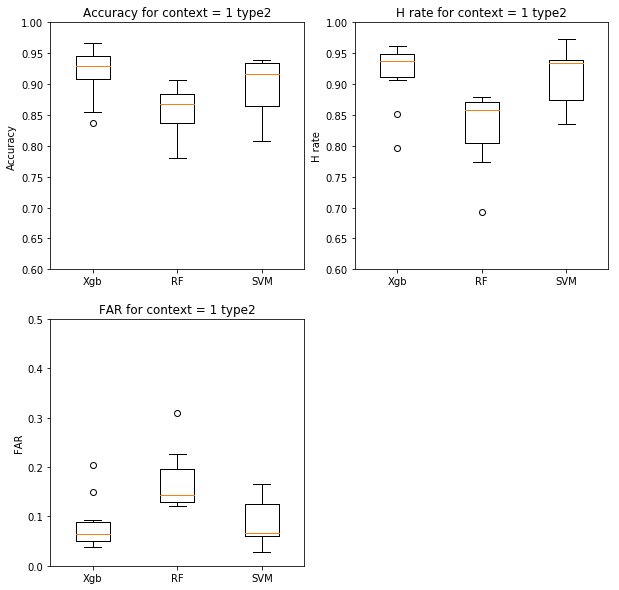

In [55]:
plt.figure(figsize=(10, 10))
plt.subplot(2,2,1)
boxplot_stats(0, 'Accuracy', 'acc')
plt.subplot(2,2,2)
boxplot_stats(1, 'H rate', 'H')
plt.subplot(2,2,3)
boxplot_stats(2, 'FAR', 'FAR')
#plt.savefig('scores_Ctxt10.png')

In [33]:
### Training on all data
X = stats_features(ft)
y = pd.Categorical(labels)

xgb_model = xgb.XGBClassifier(n_estimators=200, objective='binary:logistic', eval_metric='auc', max_depth=4)
xgb_model.fit(X, y) 

scaler = StandardScaler()
svm_model = SVC(C=20)
svm_model.fit(scaler.fit_transform(X), y)


SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [34]:
import pickle
if context :
    pickle.dump(xgb_model, open('XGB_model_ctxt1.sav', 'wb'))
    pickle.dump(svm_model, open('SVM_model_ctxt1.sav', 'wb'))
    #pickle.dump(xgb_model, open('XGB_model_ctxt2.sav', 'wb'))
    #pickle.dump(svm_model, open('SVM_model_ctxt2.sav', 'wb'))
else :
    pickle.dump(xgb_model, open('XGB_model.sav', 'wb'))
    pickle.dump(svm_model, open('SVM_model.sav', 'wb'))